# Benjamin Wilke
# NLP Final Exam

PART I
Given the GOP twitter dataset (a dataset of tweets from 2012 with 3 sentiments—see the attached file):

1. Build a model the predict the sentiment of the tweet based on a sequence of characters

2. Build a second model based on a sequence of bi-grams (2-letter sequences).

Please include ALL the code you used to develop this model.

In [1]:
import csv
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import numpy as np
import re

## Prep Data for Character Sequence Model

In [2]:
rawTweets = list()    # initialize list of lists for each row in my file

with open('final.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        rawTweets.append(row)
        
rawTweets = rawTweets[1:]  # pop off the header row

In [3]:
# extract labels from each row
labels = [each[1] for each in rawTweets]
print("Length of labels is: {}".format(len(labels)))

Length of labels is: 13871


In [20]:
# extract Tweet from each row, removing pesky linebreaks and carriage returns
# let's also clean up some other stuff that is going to be REALLY noisy for this exercise

cleanText = list()

for each in rawTweets:
    tweet = each[2]
    tweet = tweet.replace("\n", "")  # remove linebreak
    tweet = tweet.replace("\r", "")  # remove carriage return
    if "RT @" in tweet:              # let's also remove RT + Twitter Usernames as these probably don't provide any predictive value
        idx = tweet.find(': ')
        tweet = tweet[idx + 2:]           # this only removes the first instance of a reTweet, and there can be more than one, but it's a start
    tweet = re.sub(r"http\S+", "", tweet) # remove URLs
    tweet = tweet.replace(" ", "")        # remove spaces. I was on the fence about this, but I think it's actually noisy
                                          # considering character and bigram sequences - especially how odd bigrams can be formed with space combinations
    tweet = tweet.replace("\"", "")       # strip quotes because they are also pretty random and noisy
    cleanText.append(tweet.strip())       # strip off trailing whitespace and add to our cleanText list

In [23]:
cleanText[703]

"IhatethephraseIjustcan'tbutI'mprettyclosetofeelingthatwayaboutthisGodquestion.#GOPDebate"

In [6]:
print("Length of raw text is: {}".format(len(cleanText)))

Length of raw text is: 13871


In [29]:
characterCounter = Counter()

In [30]:
# create Counter of each character in each Tweet across all Tweets
for tweet in cleanText:
    for char in tweet:
        characterCounter[char] += 1

In [31]:
characterCounter

Counter({'H': 2804,
         'o': 68747,
         'w': 16235,
         'd': 33605,
         'i': 60214,
         'e': 130519,
         'v': 7620,
         'r': 50823,
         'y': 17878,
         'n': 61512,
         'f': 13806,
         'l': 39007,
         'a': 86748,
         'b': 29378,
         'u': 28996,
         't': 91072,
         'h': 40222,
         'C': 5600,
         'm': 24535,
         'g': 19762,
         'q': 1040,
         's': 60340,
         '?': 2890,
         'E': 2406,
         'x': 3165,
         'c': 22468,
         '.': 13886,
         '#': 21643,
         'G': 17361,
         'O': 18215,
         'P': 17745,
         'D': 18119,
         "'": 5653,
         'S': 4293,
         '9': 194,
         '0': 1187,
         'W': 3731,
         'k': 10597,
         '1': 1405,
         '6': 709,
         'N': 3780,
         'T': 8864,
         'R': 3956,
         'F': 4125,
         '-': 1747,
         'j': 1542,
         'p': 19606,
         '…': 2307,
         '/': 

In [32]:
print("Total Characters is: {}".format(len(characterCounter)))

Total Characters is: 239


In [33]:
# create characterToIdx dict
characterToIdx = dict()

# add required entries for NLP tasks
characterToIdx['<<PAD>>'] = 0
characterToIdx['<<UNK>>'] = 1

currentIdx = 2
characterThreshold = 3

for char in characterCounter.keys():
    if characterCounter[char] > characterThreshold:    # only include characters that appear more than 5 times
        characterToIdx[char] = currentIdx              # set character index
        currentIdx += 1                                # increment index

In [34]:
characterToIdx

{'<<PAD>>': 0,
 '<<UNK>>': 1,
 'H': 2,
 'o': 3,
 'w': 4,
 'd': 5,
 'i': 6,
 'e': 7,
 'v': 8,
 'r': 9,
 'y': 10,
 'n': 11,
 'f': 12,
 'l': 13,
 'a': 14,
 'b': 15,
 'u': 16,
 't': 17,
 'h': 18,
 'C': 19,
 'm': 20,
 'g': 21,
 'q': 22,
 's': 23,
 '?': 24,
 'E': 25,
 'x': 26,
 'c': 27,
 '.': 28,
 '#': 29,
 'G': 30,
 'O': 31,
 'P': 32,
 'D': 33,
 "'": 34,
 'S': 35,
 '9': 36,
 '0': 37,
 'W': 38,
 'k': 39,
 '1': 40,
 '6': 41,
 'N': 42,
 'T': 43,
 'R': 44,
 'F': 45,
 '-': 46,
 'j': 47,
 'p': 48,
 '…': 49,
 '/': 50,
 '@': 51,
 '2': 52,
 'z': 53,
 ':': 54,
 'I': 55,
 'B': 56,
 'M': 57,
 'L': 58,
 'A': 59,
 ',': 60,
 '!': 61,
 'J': 62,
 'U': 63,
 '_': 64,
 '3': 65,
 '7': 66,
 '%': 67,
 '&': 68,
 ';': 69,
 '“': 70,
 '*': 71,
 '(': 72,
 'V': 73,
 '8': 74,
 ')': 75,
 'K': 76,
 '’': 77,
 '$': 78,
 'Y': 79,
 '5': 80,
 '\U000fe4e6': 81,
 '👉': 82,
 '4': 83,
 '”': 84,
 'X': 85,
 '=': 86,
 '😒': 87,
 '+': 88,
 '📢': 89,
 '➡': 90,
 '️': 91,
 '🇺': 92,
 '🇸': 93,
 'Q': 94,
 'Z': 95,
 '–': 96,
 '—': 97,
 '▀': 98,

In [35]:
# create reverse characterToIdx dict idxToCharacter (in case we need it later)
idxToCharacter = dict([(value, key) for (key, value) in characterToIdx.items()])

In [36]:
print("Total Characters after removing those that appear less than {0} times is: {1}".format(characterThreshold, len(characterToIdx.keys())))

Total Characters after removing those that appear less than 3 times is: 139


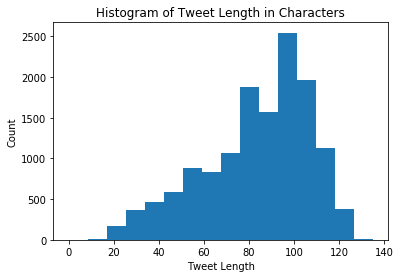

In [37]:
# let's find the distribution of sequence lengths to determine where we should set our max sequence
rawSeqLength = [len(tweet) for tweet in cleanText]
plt.hist(rawSeqLength, bins=16)
plt.xlabel("Tweet Length")
plt.ylabel("Count")
plt.title("Histogram of Tweet Length in Characters")
plt.show()

Interestingly - unlike most NLP projects where the max sequence length needs to be adjusted because of very long sequences in the training data - Twitter has a limit in length. This means we'll set our max sequence length to reflect the maximum Twitter length at the time of 140 characters (we will set to 120 since we removed spaces).

In [38]:
sequenceLength = 120
print("Our max sequence length for character model will be: {}".format(sequenceLength))

Our max sequence length for character model will be: 120


In [39]:
# let's also encode our labels, first verify possible values
print(list(set(labels)))
labelToIdx = {"Positive": 2, "Neutral": 1, "Negative": 0}
labelToIdx

['Positive', 'Negative', 'Neutral']


{'Positive': 2, 'Neutral': 1, 'Negative': 0}

In [40]:
# create one hot encoded labels (for model)
encodedLabels = np.array([labelToIdx[label] for label in labels])
oneHotEncodedLabels = to_categorical(encodedLabels)

In [41]:
# let's encode our sequences! 
encodedSequences = list()
for tweet in cleanText:
    encodedSequences.append([characterToIdx[char] if char in characterToIdx.keys() else 1 for char in tweet])

In [42]:
# now let's pad our sequences
encodedSequences = sequence.pad_sequences(encodedSequences, maxlen=sequenceLength)           

## Let's Create the Character Model

In [ ]:
embedding_vector_length = 128

vocabulary_size = len(characterToIdx)
n_labels = len(labelToIdx)

model = Sequential()
model.add(Embedding(vocabulary_size, embedding_vector_length, input_length=sequenceLength, mask_zero=True))
model.add(LSTM(units=500, recurrent_dropout=0.25, dropout=0.25))
model.add(Dense(n_labels, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('TweetSentiment_Model_Character.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(encodedSequences, oneHotEncodedLabels, validation_split=0.2, callbacks=[checkpoint], batch_size=8, epochs=1, shuffle=True, verbose=1)

## Prep Data for BiGram Sequence Model

In [24]:
def extractBiGrams(tweet):
    biGramOutSeq = list()      # initialize our output list
    if len(tweet) % 2 != 0:    # length is odd
        tweet = tweet[:-1]     # chop last character off to make it even
    currentIdx = 0             # initialize current position
    for bigram in range(int(len(tweet) / 2)):                # for each bigram position (so half of total EVEN length)
        biGramOutSeq.append(tweet[currentIdx:currentIdx + 2])# get current bigram, add to biGramOutSeq
        currentIdx += 2                                      # increment to next biGram        
    return biGramOutSeq

In [25]:
# extract bigrams for each tweet sequence
biGramSequencesRaw = [extractBiGrams(tweet) for tweet in cleanText]

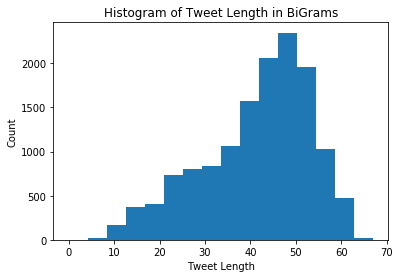

In [27]:
# let's find the distribution of sequence lengths in BIGRAMs to determine where we should set our max sequence
biGramLength = [len(tweet) for tweet in biGramSequencesRaw]
plt.hist(biGramLength, bins=16)
plt.xlabel("Tweet Length")
plt.ylabel("Count")
plt.title("Histogram of Tweet Length in BiGrams")
plt.show()

As we would expect it maxes out around half the length of total allowed Tweet size in characters (140). 

In [28]:
biGramSequenceLength = 60
print("Our max sequence length for bigram model will be: {}".format(biGramSequenceLength))

Our max sequence length for bigram model will be: 60
